This notebook contains an example for teaching.

# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

## Data analysis

We consider the same subsample of the U.S. Current Population Survey (2015) as in the previous lab. Let us load the data set.

In [1]:
load("data/wage2015_subsample_inference.Rdata")
#attach(data)

dim(data)

[1] 5150   20

To start our (causal) analysis, we compare the sample means given gender:

In [2]:
library(tidyverse)
# selecting a subset of interest (college and some college)
z_clg <- data %>% 
  filter(clg==1 | scl==1)

# keeping variables of interest to do the table
Z <- z_clg[which(colnames(z_clg) %in% c("lwage","sex","clg", "ne","mw",
                                        "so","we","exp1"))] #WAS data

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [3]:
dim(z_clg)

[1] 3068   20

In [4]:
library(xtable)

# creating a dataset for female
data_female <- z_clg[z_clg$sex==1,]
Z_female <- data_female[which(colnames(z_clg) %in% c("lwage","sex","clg", "ne",
                                                    "mw","so","we","exp1"))]

# creating a dataset for male
data_male <- z_clg[z_clg$sex==0,]
Z_male <- data_male[which(colnames(z_clg) %in% c("lwage","sex","clg", "ne",
                                                "mw","so","we","exp1"))]

table <- matrix(0, 8, 3)
table[1:8,1]   <- as.numeric(lapply(Z,mean))
table[1:8,2]   <- as.numeric(lapply(Z_male,mean))
table[1:8,3]   <- as.numeric(lapply(Z_female,mean))
rownames(table) <- c("Log Wage","Sex","College Graduate",
                      "Northeast","Midwest","South","West","Experience")
colnames(table) <- c("All","Men","Women")
tab <- xtable(table, digits = 4)
tab

,All,Men,Women
,<dbl>,<dbl>,<dbl>
Log Wage,3.0000223,3.0384121,2.9569035
Sex,0.4709909,0.0000000,1.0000000
College Graduate,0.5332464,0.5181762,0.5501730
Northeast,0.2659713,0.2612446,0.2712803
Midwest,0.2858540,0.2908195,0.2802768
South,0.2216428,0.2285890,0.2138408
West,0.2265319,0.2193469,0.2346021
Experience,12.7009452,12.4331485,13.0017301


In [5]:
#print(tab,type="html") # set type="latex" for printing table in LaTeX

<!-- html table generated in R 4.1.1 by xtable 1.8-4 package -->
<!-- Wed Sep 08 18:57:47 2021 -->
<table border=1>
<tr> <th>  </th> <th> All </th> <th> Men </th> <th> Women </th>  </tr>
  <tr> <td align="right"> Log Wage </td> <td align="right"> 3.0000 </td> <td align="right"> 3.0384 </td> <td align="right"> 2.9569 </td> </tr>
  <tr> <td align="right"> Sex </td> <td align="right"> 0.4710 </td> <td align="right"> 0.0000 </td> <td align="right"> 1.0000 </td> </tr>
  <tr> <td align="right"> College Graduate </td> <td align="right"> 0.5332 </td> <td align="right"> 0.5182 </td> <td align="right"> 0.5502 </td> </tr>
  <tr> <td align="right"> Northeast </td> <td align="right"> 0.2660 </td> <td align="right"> 0.2612 </td> <td align="right"> 0.2713 </td> </tr>
  <tr> <td align="right"> Midwest </td> <td align="right"> 0.2859 </td> <td align="right"> 0.2908 </td> <td align="right"> 0.2803 </td> </tr>
  <tr> <td align="right"> South </td> <td align="right"> 0.2216 </td> <td align="right"> 0.2286 </td> <td align="right"> 0.2138 </td> </tr>
  <tr> <td align="right"> West </td> <td align="right"> 0.2265 </td> <td align="right"> 0.2193 </td> <td align="right"> 0.2346 </td> </tr>
  <tr> <td align="right"> Experience </td> <td align="right"> 12.7009 </td> <td align="right"> 12.4331 </td> <td align="right"> 13.0017 </td> </tr>
   </table>

In particular, the table above shows that the difference in average *logwage* between men and women is equal to $0,0815$.

In [6]:
mean(data_female$lwage)-mean(data_male$lwage)

[1] -0.08150856

Thus, the unconditional gender wage gap is about $8,15$\% for the group of never married workers (women get paid less on average in our sample). We also observe that never married working women are relatively more educated than working men and have lower working experience.

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

\begin{align}
\log(Y) &=\beta D + \epsilon.
\end{align}

We verify this by running an ols regression in R.

In [7]:
library(sandwich)
nocontrol.fit <- lm(lwage ~ sex, data=z_clg)
nocontrol.est <- summary(nocontrol.fit)$coef["sex",1]
HCV.coefs <- vcovHC(nocontrol.fit, type = 'HC');
nocontrol.se <- sqrt(diag(HCV.coefs))[2] # Estimated std errors

# print unconditional effect of gender and the corresponding standard error
cat ("The estimated gender coefficient is",nocontrol.est," and the corresponding robust standard error is",nocontrol.se) 


The estimated gender coefficient is -0.08150856  and the corresponding robust standard error is 0.01957965

Note that the standard error is computed with the *R* package *sandwich* to be robust to heteroskedasticity. 


Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

## Ols regression with controls

Let us run the ols regression with controls.

In [8]:
# Ols regression with controls

flex <- lwage ~ sex + (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)

#   Note that ()*() operation in formula objects in R creates a formula of the sort:
#  (exp1+exp2+exp3+exp4)+ (shs+hsg+scl+clg+occ2+ind2+mw+so+we) +  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)
#  This is not intuitive at all, but that's what it does.

control.fit <- lm(flex, data=z_clg)
control.est <- summary(control.fit)$coef[2,1]

summary(control.fit)

cat("Coefficient for OLS with controls", control.est)

HCV.coefs <- vcovHC(control.fit, type = 'HC');
control.se <- sqrt(diag(HCV.coefs))[2] # Estimated std errors


Call:
lm(formula = flex, data = z_clg)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.87897 -0.27894 -0.00777  0.25823  2.85755 

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.4357559  0.5208785   6.596 5.02e-11 ***
sex         -0.0530623  0.0193532  -2.742 0.006149 ** 
exp1        -0.1962420  0.1996670  -0.983 0.325767    
exp2         4.3105015  2.3797581   1.811 0.070197 .  
exp3        -2.3067253  1.0176306  -2.267 0.023480 *  
exp4         0.3513392  0.1382879   2.541 0.011118 *  
clg          0.2498673  0.1237850   2.019 0.043627 *  
occ22        0.2151993  0.1582208   1.360 0.173900    
occ23        0.0487642  0.2095297   0.233 0.815986    
occ24        0.0281449  0.2300084   0.122 0.902619    
occ25       -0.2711807  0.3944166  -0.688 0.491793    
occ26       -0.2000530  0.2705614  -0.739 0.459725    
occ27       -0.1203371  0.4188017  -0.287 0.773875    
occ28       -0.1719401  0.2721

Coefficient for OLS with controls -0.05306234

The estimated regression coefficient $\beta_1\approx-0.05306234$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $4$\% for women increases to about $7$\% after controlling for worker characteristics.  


Next, we are using the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

# Partialling-Out using ols

In [9]:
# models
flex.y <- lwage ~  (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we) # model for Y
flex.d <- sex ~ (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we) # model for D

# partialling-out the linear effect of W from Y
t.Y <- lm(flex.y, data=z_clg)$res
# partialling-out the linear effect of W from D
t.D <- lm(flex.d, data=z_clg)$res

# regression of Y on D after partialling-out the effect of W
partial.fit <- lm(t.Y~t.D)
partial.est <- summary(partial.fit)$coef[2,1]

cat("Coefficient for D via partialling-out", partial.est)

# standard error
HCV.coefs <- vcovHC(partial.fit, type = 'HC')
partial.se <- sqrt(diag(HCV.coefs))[2]

# confidence interval
confint(partial.fit)[2,]

Coefficient for D via partialling-out -0.05306234

2.5 %      97.5 % 
-0.08957070 -0.01655398

Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

# Graph: Experience profile and log-wage

The task is to replicate the Figure 11.10 from Lemieux (2006) considering that "you will have only two plotted lines for this college-educated workers". It means we have to plot using the subset of the original data.

A first way is to collapse the data to plot the mean of log-wages for each year of experience. To do so, we first estimate the logwage by a quafratic and quartic expressions, and then we clean the data to plot.

First step: Estimation for quadratic and quartic approaches

In [10]:
quartic   <- lwage ~  exp1+exp2+exp3+exp4
quadratic <- lwage ~  exp1+exp2

# quartic
quartic_pred <- predict(lm(quartic, data=z_clg))

# quadratic
quadratic_pred <- predict(lm(quadratic, data=z_clg))

# adding predictions
z_clg <- z_clg %>% mutate(lwage_quartic = quartic_pred)
z_clg <- z_clg %>% mutate(lwage_quadratic = quadratic_pred)

Second step: cleaning the data

In [11]:
# cleaning data to plot
graph_2 <- z_clg %>% group_by(exp1, clg) %>% 
  summarise_at(vars(lwage, lwage_quartic, lwage_quadratic), mean)
names(graph_2)

[1] "exp1"            "clg"             "lwage"           "lwage_quartic"  
[5] "lwage_quadratic"

All done, we can plot.

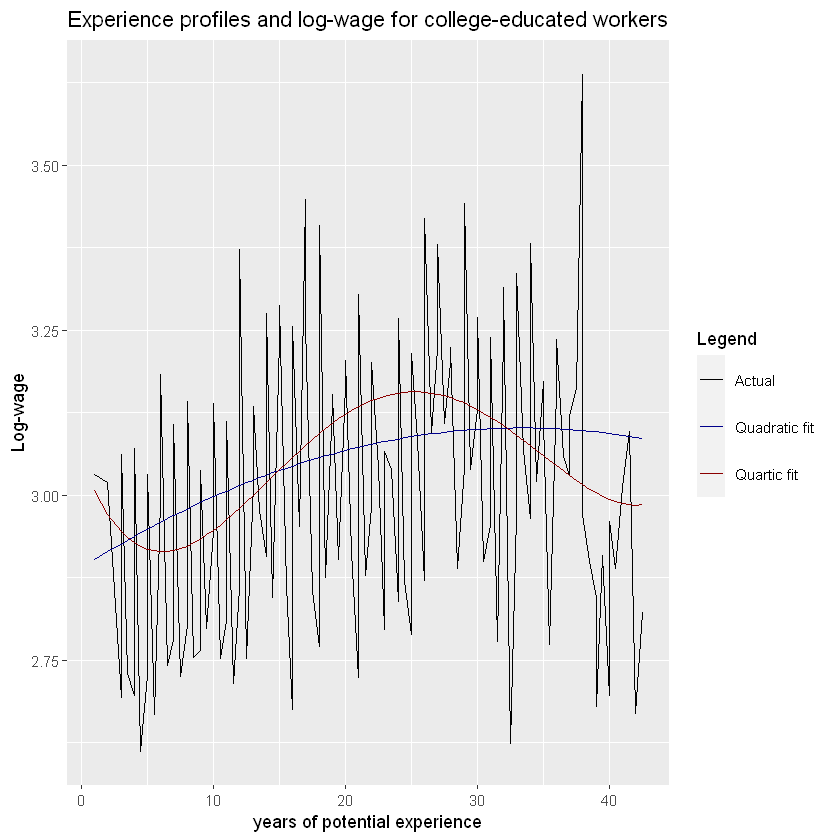

In [12]:
# graph exp vs log-wage
ggplot(graph_2) + geom_line(aes(x=exp1, y=lwage, colour="black")) + 
  geom_line(aes(x=exp1, y=lwage_quadratic, colour="darkblue"), size=0.5) +
  geom_line(aes(x=exp1, y=lwage_quartic, colour="darkred"), size=0.5) +
labs(x = "years of potential experience", 
     y = "Log-wage", 
     size = "Population", 
     title = "Experience profiles and log-wage for college-educated workers") +
theme(legend.key.height = unit(1, 'cm')) +
scale_color_identity(name = "Legend", labels = c("Actual","Quadratic fit", "Quartic fit"),
                     guide = "legend")

As we can see, the graph shows a better fit with a quartic prediction. Howevere, the graph shows too much noise. We can use another technique to collapse the data.

Additionally, we can make a better graph by using [bins](https://michaelstepner.com/binscatter/binscatter-StataConference2014.pdf) instead of collapsing the data. We can do so by using <code>stat_summary_bin</code>.

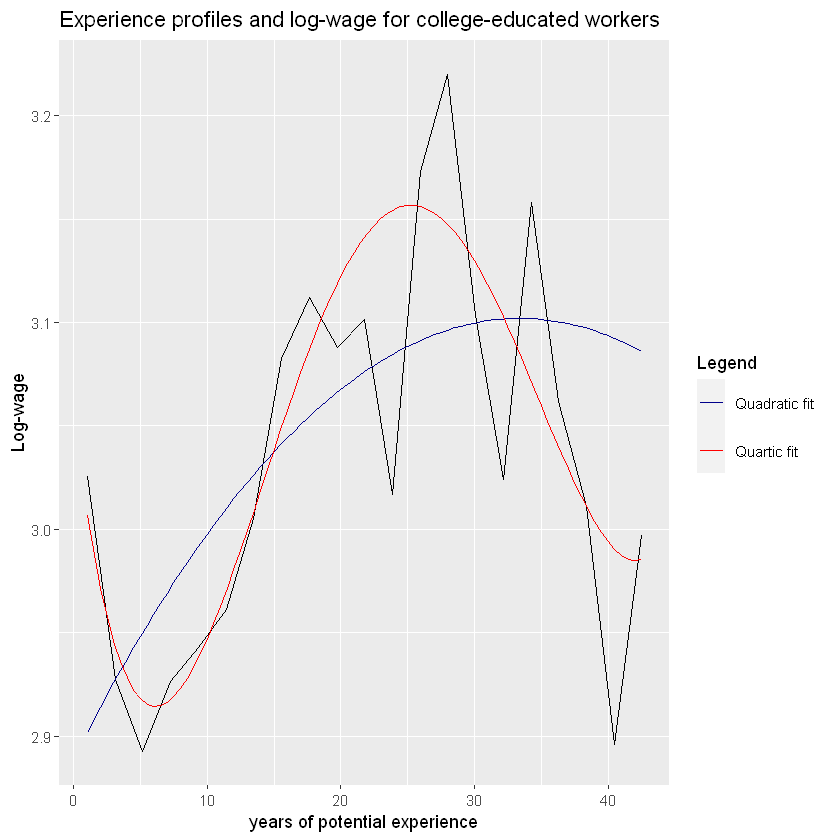

In [13]:
ggplot(NULL,aes(exp1,lwage)) +
stat_summary_bin(data=z_clg, fun='mean', bins=20, color='black', size=0.5, geom='line') +
geom_line(data=z_clg, aes(x=exp1, y=lwage_quadratic, colour="darkblue")) + 
geom_line(data=z_clg, aes(x=exp1, y=lwage_quartic, colour="red")) +
labs(x = "years of potential experience", 
     y = "Log-wage", 
     title = "Experience profiles and log-wage for college-educated workers") +
theme(legend.key.height = unit(1, 'cm')) +
scale_color_identity(name = "Legend", labels = c("Quadratic fit", "Quartic fit"),
                     guide = "legend")

Now it is clear that the relation between experiencie and log-wage fits better to the quartic prediction.

### Additional exercise
Addtionally, we can replicate the Figure 11.10 from Lemieux (2006) using the subset data (called *z_clg*). As the Figure 11.10 from Lemieux (2006), we must distinguish the lines between the ones who finished the college (<code>clg==1</code>) and those who didn't (<code>scl==0</code>).

In [14]:
quartic   <- lwage ~ exp1+exp2+exp3+exp4
quadratic <- lwage ~ exp1+exp2

# data for the ones who finished college (clg==1)
data_clg <- z_clg %>% filter(clg==1)
cat("clg =", dim(data_clg), "\n")

# data for those who didn't finish college (scl==1)
data_smclg <- z_clg %>% filter(scl==1)
cat("smclg =", dim(data_smclg), "\n")

# quartic
quartic_pred_clg <- predict(lm(quartic, data=data_clg))
quartic_pred_smclg <- predict(lm(quartic, data=data_smclg))

# quadratic
quadratic_pred_clg <- predict(lm(quadratic, data=data_clg))
quadratic_pred_smclg <- predict(lm(quadratic, data=data_smclg))


# adding predictions
data_clg <- data_clg %>% mutate(lwage_quartic = quartic_pred_clg,
                                lwage_quadratic = quadratic_pred_clg)

data_smclg <- data_smclg %>% mutate(lwage_quartic = quartic_pred_smclg,
                                      lwage_quadratic = quadratic_pred_smclg)

cat("Mean of predicted log-wage for college is ", mean(data_clg$lwage_quartic), "\n")
cat("Mean of predicted log-wage for some college is ", mean(data_smclg$lwage_quartic))

clg = 1636 22 
smclg = 1432 22 
Mean of predicted log-wage for college is  3.13367 
Mean of predicted log-wage for some college is  2.847335

It is important to note that the estimates of the quadratic approach reveals coefficients similar to a linear regression since the squared experience is not close to zero. It means that the quadratic prediction must be a curve.

In [15]:
# revising estimates
quadratic_reg_clg <- lm(quadratic, data=data_clg)
#summary(quadratic_reg_clg)
square_exp_clg <- summary(quadratic_reg_clg)$coef[3,1]
cat("For college workers, the coefficient of the squared experience is:", square_exp_clg, '\n')

quadratic_reg_nonclg <- lm(quadratic, data=data_smclg)
#summary(quadratic_reg_nonclg)
square_exp_nonclg <- summary(quadratic_reg_nonclg)$coef[3,1]
cat("For some-college workers, the coefficient of the squared experience is:", square_exp_nonclg, '\n')

For college workers, the coefficient of the squared experience is: -0.05572554 
For some-college workers, the coefficient of the squared experience is: -0.04378015 


The second step is to clean the data to make the plot

In [16]:
data_clg_gr <- data_clg %>% group_by(exp1) %>%  # college
  summarise_at(vars(lwage, lwage_quartic, lwage_quadratic), mean)

data_smclg_gr <- data_smclg %>% group_by(exp1) %>% 
  summarise_at(vars(lwage, lwage_quartic, lwage_quadratic), mean)

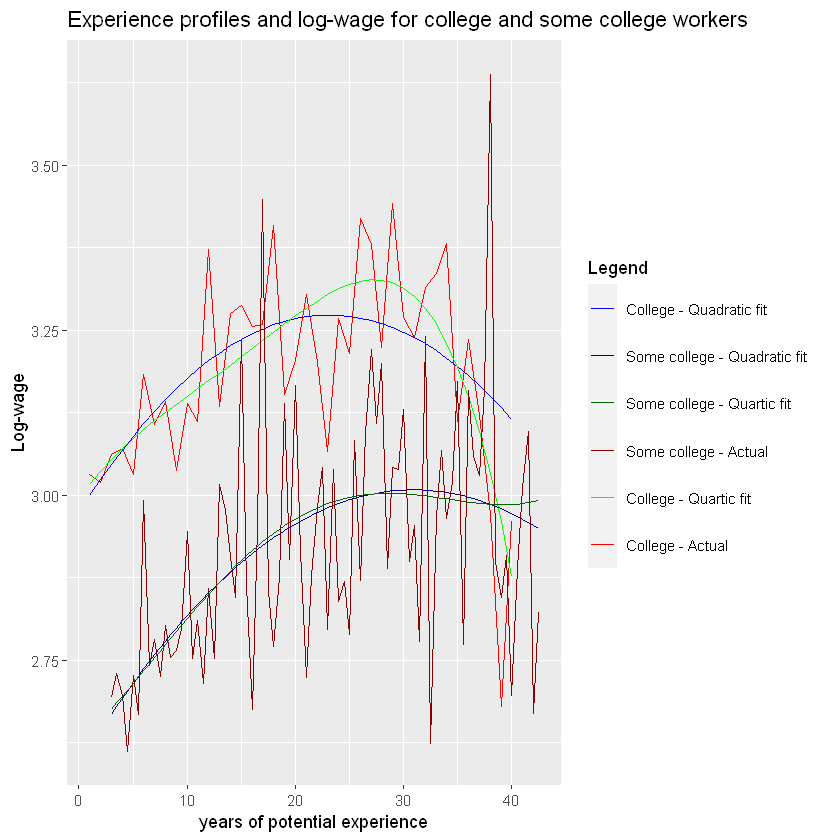

In [17]:
# graph exp vs log-wage (extra exercise)
ggplot()+
# college
geom_line(data=data_clg_gr, aes(x=exp1, y=lwage, colour="red"), size=0.5) + 
geom_line(data=data_clg_gr, aes(x=exp1, y=lwage_quadratic, colour="blue"), size=0.5) +
geom_line(data=data_clg_gr, aes(x=exp1, y=lwage_quartic, colour="green"), size=0.5) + 

# no college
geom_line(data=data_smclg_gr, aes(x=exp1, y=lwage, colour="darkred"), size=0.5) + 
geom_line(data=data_smclg_gr, aes(x=exp1, y=lwage_quadratic, colour="darkblue"), size=0.5) +
geom_line(data=data_smclg_gr, aes(x=exp1, y=lwage_quartic, colour="darkgreen"), size=0.5) +

labs(x = "years of potential experience", 
     y = "Log-wage", 
     size = "Population", 
     title = "Experience profiles and log-wage for college and some college workers") +
theme(legend.key.height = unit(1, 'cm')) +
scale_color_identity(name = "Legend", labels = c("College - Quadratic fit",
                                                 "Some college - Quadratic fit",
                                                 "Some college - Quartic fit",
                                                 "Some college - Actual",
                                                 "College - Quartic fit",
                                                 "College - Actual"),
                     guide = "legend")


From the graph, we can see that fit between log-wage and experience is better when using a quartic regression fot both groups (college and some college).

Similarly to what we did previously, we can plot using [bins](https://michaelstepner.com/binscatter/binscatter-StataConference2014.pdf). This technique will make our plots smoother.

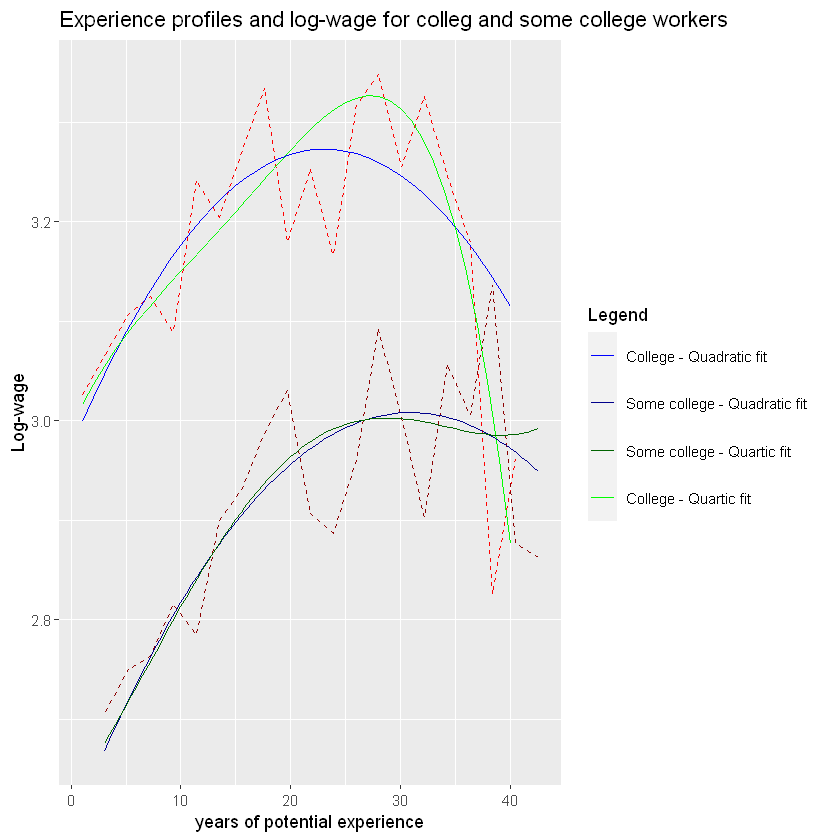

In [19]:
ggplot() +
# college
stat_summary_bin(data=data_clg_gr, aes(x=exp1,y=lwage), fun='mean', bins=20, color='red', 
                 size=0.5, geom='line', linetype="dashed") +
geom_line(data=data_clg_gr, aes(x=exp1, y=lwage_quadratic, colour="blue")) + 
geom_line(data=data_clg_gr, aes(x=exp1, y=lwage_quartic, colour="green")) +
labs(x = "years of potential experience", 
     y = "Log-wage", 
     title = "Experience profiles and log-wage for college and some college workers") +

# some college
stat_summary_bin(data=data_smclg_gr, aes(x=exp1,y=lwage), fun='mean', bins=20, color='darkred', 
                 size=0.5, geom='line', linetype="dashed") +
geom_line(data=data_smclg_gr, aes(x=exp1, y=lwage_quadratic, colour="darkblue")) + 
geom_line(data=data_smclg_gr, aes(x=exp1, y=lwage_quartic, colour="darkgreen")) +

theme(legend.key.height = unit(1, 'cm')) +
scale_color_identity(name = "Legend", labels = c("College - Quadratic fit",
                                                 "Some college - Quadratic fit",
                                                 "Some college - Quartic fit",
                                                 "College - Quartic fit"),
                     guide = "legend")

The bins show a smoother plot. Once again, it is clear to see that fit between log-wage and experience is better when using a quartic regression fot both groups (college and some college).